In [ ]:
'''!git clone https://github.com/rajanlab/CURBD.git
import os 
os.chdir('/content/CURBD/')'''

Cloning into 'CURBD'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 78 (delta 16), reused 13 (delta 13), pack-reused 57
Unpacking objects: 100% (78/78), 36.88 KiB | 1.23 MiB/s, done.


In [1]:
import numpy as np
import numpy.random as npr
import pylab
import curbd
import math

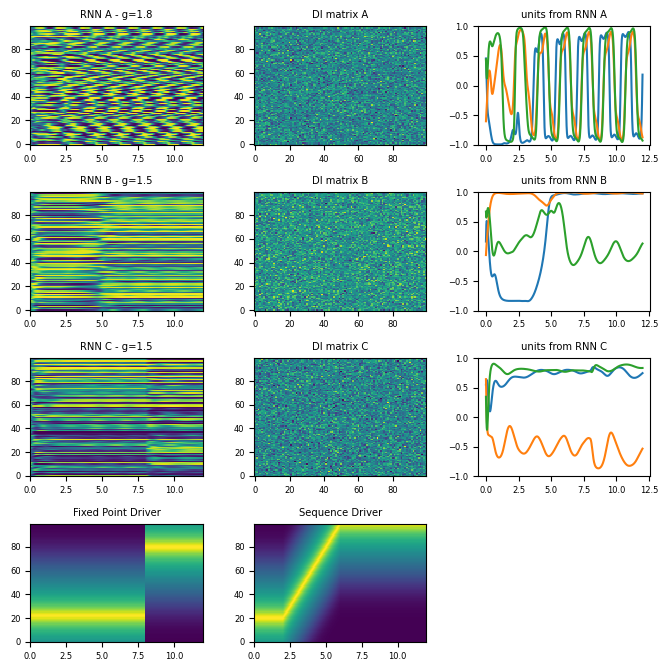

c:\Users\Andrew\Documents\MAT 6215\actual curbd\MAT6215finalproject\curbd.py:548: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [2]:
sim = curbd.threeRegionSim(number_units=100)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

c:\Users\Andrew\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sim.keys()

dict_keys(['Ra', 'Rb', 'Rc', 'Rseq', 'Rfp', 'tData', 'Ja', 'Jb', 'Jc', 'w_A2B', 'w_A2C', 'w_B2A', 'w_B2C', 'w_C2A', 'w_C2B', 'w_Fix2C', 'w_Seq2B', 'params'])

In [5]:
#three regions with each region having 100 units and 1201 time series data
activity = np.concatenate((sim['Ra'], sim['Rb'], sim['Rc']), 0) #300 x 1201
print (activity.shape)


(300, 1201)


In [6]:
Na = sim['params']['Na']
Nb = sim['params']['Nb']
Nc = sim['params']['Nc']

In [7]:
regions = []
regions.append(['Region A', np.arange(0, Na)])
regions.append(['Region B', np.arange(Na, Na + Nb)])
regions.append(['Region C', np.arange(Na + Nb, Na + Nb + Nc)])
regions = np.array(regions, dtype=object)

regions

array([['Region A',
        array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
               17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
               34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
               51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
               68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
               85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])       ],
       ['Region B',
        array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
               113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
               126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
               139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
               152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
               165, 166, 167, 168, 169, 170, 171, 172, 173, 

# Initializing the parameters 

In [43]:
dtData=sim['params']['dtData'] # time step of training data
dtFactor=5 # number of interpolation steps for RNN 
regions=regions # number of regions and names of the regions
tauRNN=2*sim['params']['tau']/2 # decay constant of RNN 
nRunTrain=10 # number of training runs
verbose=True
nRunFree=5 #number of untrained runs at end

g=1.5 # instability constant 
tauWN=0.1 #decay constant on filtered white noise inputs
ampInWN=0.01 #input amplitude of filtered white noise 
P0=1.0 #learning rate 
#nonLinearity=np.tanh
nonLinearity=F.tanh
nonLinearity_inv=np.arctanh
resetPoints=None
plotStatus=True
regions=None



In [9]:
if dtData is None: #0.01
    print('dtData not specified. Defaulting to 1.');
    dtData = 1;
if resetPoints is None:
    resetPoints = [0, ]
if regions is None:
    regions = {}

In [10]:
number_units = activity.shape[0] #300 -- the total number of units 
number_learn = activity.shape[0] #300

dtRNN = dtData / float(dtFactor) # 0.01/5=0.002
nRunTot = nRunTrain + nRunFree #10+5=15


In [11]:
learnList = npr.permutation(number_units) #randomize the units
iTarget = learnList[:number_learn]
iNonTarget = learnList[number_learn:] # []

tData = dtData*np.arange(activity.shape[1]) #   [0, 0.01, 0.02 ....,12.01] #1201 input time steps 
tRNN = np.arange(0, tData[-1] + dtRNN, dtRNN) # [0, 0.002, 0.004 ...., 12.01] #6000 rnn time steps


# print("learnList : ",learnList)
# print("iTarget: ",iTarget)
# print("iNonTarget : ",iNonTarget)
# print("tData: ",tData)
# print("tRNN: ",tRNN)

# External Input to RNN

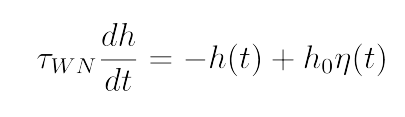

In [12]:
ampWN = math.sqrt(tauWN/dtRNN) # (0.1/0.002)
iWN = ampWN * npr.randn(number_units, len(tRNN)) #gaussian noise ? #300x6001
inputWN = np.ones((number_units, len(tRNN))) #300x6001
# print("inputWN : ",inputWN)
for tt in range(1, len(tRNN)):
    inputWN[:, tt] = iWN[:, tt] + (inputWN[:, tt - 1] - iWN[:, tt])*np.exp(- (dtRNN / tauWN)) # solve the above differential equation 
inputWN = torch.Tensor(ampInWN * inputWN) # external input h(t)

# print("ampWN : ",ampWN)
# print("iWN : ",iWN)
# print("inputWN",inputWN)


# Initialize weight matrix J

In [13]:
J = g * npr.randn(number_units, number_units) / math.sqrt(number_units) # g<1 -> damped and g>1 -> chaotic
J0 = J.copy()
# print ('J0 : ',J0)
print (J0.shape)




(300, 300)


# Set up target training data

In [45]:
Adata = activity.copy()
Adata = Adata/Adata.max()
Adata = np.minimum(Adata, 0.999) # elementwise minimum 
Adata = np.maximum(Adata, -0.999) # elementwise max
Adata = torch.Tensor(Adata)


# print ("Adata : ",Adata)
print (Adata.shape)

torch.Size([300, 1201])


In [15]:
# get standard deviation of entire data
stdData = np.std(Adata[iTarget, :])

# Get indices for each sample of model data

In [16]:
iModelSample = np.zeros(len(tData), dtype=np.int32)
print ("iModelSample : ",iModelSample)
for i in range(len(tData)):
    iModelSample[i] = (np.abs(tRNN - tData[i])).argmin()

# print("iModelSample : ",iModelSample)
print (iModelSample.shape)

iModelSample :  [0 0 0 ... 0 0 0]
(1201,)


In [17]:
RNN = torch.Tensor(np.zeros((number_units, len(tRNN)))) # 300 X 6001
chi2s = []
pVars = []
# 3 RNNs with 100 units is trained with 6001 rnn steps

In [18]:
PJ = P0*np.eye(number_learn) #P0=learning rate 
# print ("PJ : ",PJ)
print (PJ.shape)

(300, 300)


In [152]:
from torch.autograd import Variable

class Model(nn.Module):
  def __init__(self, number_units):
    super().__init__()
    self.J = nn.Parameter(g * torch.Tensor(npr.randn(number_units, number_units) / math.sqrt(number_units)), requires_grad=True) # g<1 -> damped and g>1 -> chaotic
    #self.test = nn.Linear(10,10)
    #self.register_parameter(name, parameter)


  def forward(self,
              activity_data,
              white_noise
              ):
    
    activity_data = F.tanh(activity_data)
 
    JR = torch.matmul(self.J, activity_data) + white_noise
    
    return JR, activity_data + dtRNN*(-activity_data + JR)/tauRNN
    

rnn_model = Model(number_units)
    

In [251]:
from torch.autograd import Variable

class Model(nn.Module):
  def __init__(self, number_units):
    super().__init__()
    self.number_units = number_units

    # g<1 -> damped and g>1 -> chaotic
    self.J = nn.Parameter(g * torch.Tensor(npr.randn(number_units, number_units) / 
                                           math.sqrt(number_units)), requires_grad=True) 
  

  def forward(self,
              activity_data,
              white_noise
              ):
    
    output = torch.tanh(activity_data)
    JR_temp = (torch.matmul(self.J, output).reshape((self.number_units, 1)) + white_noise) 
    new_hidden_state = activity_data + dtRNN*(-activity_data + JR_temp)/tauRNN 
 
    return output, new_hidden_state
    

rnn_model = Model(number_units)
    

In [252]:

optimizer = torch.optim.RMSprop(rnn_model.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

for epoch in range(100):
    print("We are on epoch", epoch)
    for nRun in range(0, 1):
        total_error = 0

        # Get initial activity (initial hidden state?)
        H = Adata[:, 0, np.newaxis] # 300 X 1
        
        # Get output activations
        RNN[:, 0, np.newaxis] = nonLinearity(H)
        

        for tt in range(1, 200): # 6001
            
            #RNN[:, tt, np.newaxis] = nonLinearity(H) # calculate the non linearity 
            
            output, new_hidden_state = rnn_model(H, inputWN[:, tt, np.newaxis])
            H = new_hidden_state
            #JR, H = rnn_model(H, inputWN[:, tt, np.newaxis])
            #H = H + dtRNN*(-H + JR)/tauRNN 
        
                
            err = loss_function(output, Adata[:, tt, np.newaxis])
            total_error += err
                
        optimizer.zero_grad()
        total_error.backward()
        optimizer.step()    
        print(total_error)  

We are on epoch 0


c:\Users\Andrew\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor(104.5869, grad_fn=<AddBackward0>)
We are on epoch 1
tensor(98.4042, grad_fn=<AddBackward0>)
We are on epoch 2
tensor(74.6471, grad_fn=<AddBackward0>)
We are on epoch 3
tensor(68.5207, grad_fn=<AddBackward0>)
We are on epoch 4
tensor(58.4087, grad_fn=<AddBackward0>)
We are on epoch 5
tensor(46.8604, grad_fn=<AddBackward0>)
We are on epoch 6
tensor(43.7238, grad_fn=<AddBackward0>)
We are on epoch 7
tensor(37.0660, grad_fn=<AddBackward0>)
We are on epoch 8
tensor(30.7595, grad_fn=<AddBackward0>)
We are on epoch 9
tensor(32.0128, grad_fn=<AddBackward0>)
We are on epoch 10
tensor(27.8370, grad_fn=<AddBackward0>)
We are on epoch 11
tensor(29.6850, grad_fn=<AddBackward0>)
We are on epoch 12
tensor(38.0910, grad_fn=<AddBackward0>)
We are on epoch 13
tensor(27.2020, grad_fn=<AddBackward0>)
We are on epoch 14
tensor(23.9809, grad_fn=<AddBackward0>)
We are on epoch 15
tensor(21.9689, grad_fn=<AddBackward0>)
We are on epoch 16
tensor(22.6914, grad_fn=<AddBackward0>)
We are on epoch 17
tenso

In [169]:
for param in rnn_model.parameters():
    print(param.shape)

torch.Size([300, 300])


In [254]:
def validate(model):
    
    with torch.no_grad():
        
        H = Adata[:, 0, np.newaxis] # 300 X 1

        RNN[:, 0, np.newaxis] = nonLinearity(H)
        predicted = []
        actual = []

        
        for tt in range(1, 100): # 6001
            
            #RNN[:, tt, np.newaxis] = nonLinearity(H) # calculate the non linearity 
            
            output, new_hidden_state = rnn_model(H, inputWN[:, tt, np.newaxis])
            H = new_hidden_state
            #JR, H = rnn_model(H, inputWN[:, tt, np.newaxis])
            #H = H + dtRNN*(-H + JR)/tauRNN 
        
            predicted.append(output.detach().numpy())
            actual.append( Adata[:, tt, np.newaxis].detach().numpy())
            
                
    return predicted, actual

In [249]:
torch.save(rnn_model.state_dict(), "weights.pt")

In [255]:
pred, act = validate(rnn_model)

In [256]:
import matplotlib.pyplot as plt

unit_1_pred = []
unit_1_actual = []


for i in range(len(pred)):
    unit_1_pred.append(pred[i][33])
    unit_1_actual.append(act[i][33])

In [257]:
total = torch.zeros(100)
pred_joind=[]
act_joind=[]
for timestep in range(len(pred)):
    act_joind.append(act[timestep][:100].mean())
    pred_joind.append(pred[timestep][:100].mean())



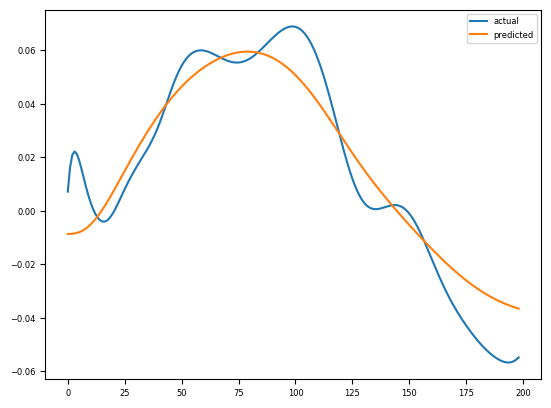

In [258]:
plt.plot(act_joind, label='actual')
plt.plot(pred_joind, label='predicted')
plt.legend()

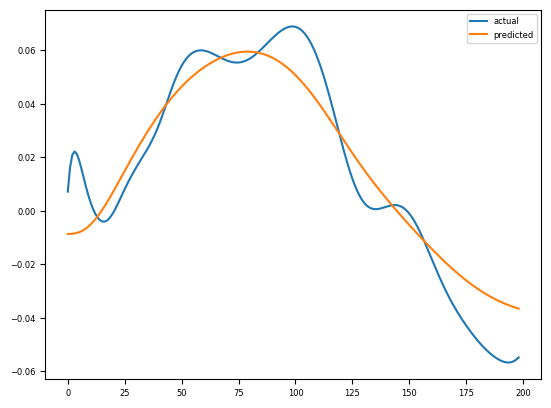

In [259]:
plt.plot(act_joind, label='actual')
plt.plot(pred_joind, label='predicted')
plt.legend()

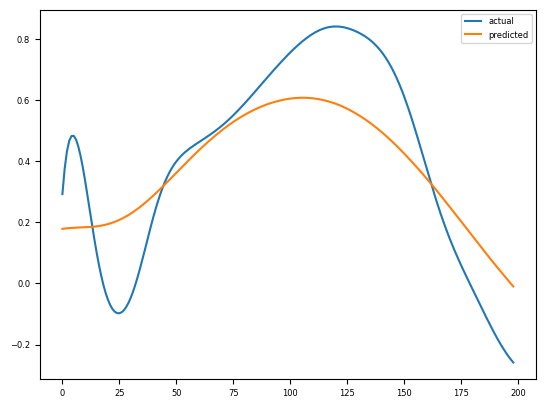

In [260]:
plt.plot(unit_1_actual, label='actual')
plt.plot(unit_1_pred, label='predicted')
plt.legend()